# Notebook for Programming in Problem 4
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement a sequence-to-sequence (seq2seq) transformer model to build a nerual machine translation (NMT) system, which translates from French to English.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
You can edit code in the other parts of the notebook too, which can be useful for debugging, but be careful to avoid breaking the provided code.

## Installing Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.
In addition, we will also be needing [huggingface](https://huggingface.co/)'s `transformers` and `datasets` libraries, and [nltk](https://www.nltk.org/) to compute the BLEU score.

In [1]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.0 which is incompatible.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirem

## Download NMT data

We first download the data for NMT, which contains pairs of parallel sentences.

In [2]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip

## Data preprocessing
In this section we will write code to load and tokenize the data for NMT.


The parallel data is provided as huggingface datasets, one for each split of `train`, `validation` and `test`. We load it via the `load_from_disk` method and inspect its features. If you'd like to know more about these dataset objects, have a look at [this tutorial](https://huggingface.co/docs/datasets/access).

In [3]:
!pip install fsspec==2023.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and

In [4]:
from datasets import load_from_disk
raw_text_datasets = load_from_disk("resources/parallel_en_fr_corpus")
print("Summary of splits:", raw_text_datasets)
print("First training example:", raw_text_datasets["train"][0])

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})
First training example: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}


You are also provided with two pre-trained tokenizers for the source and target languages respectively, which we can load with the hugginface transfomers library. [This tutorial](https://huggingface.co/docs/transformers/preprocessing#natural-language-processing) provides an introduction to using pre-trained tokenizers and the powerful `AutoTokenizer` class. The tokenizers are based on byte-pair encodings which break words into smaller units. This is aimed at reducing the sparsity of words, as subwords can be shared between different rare words. If you are interested in learning more, see the paper [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162.pdf).

In [5]:
from transformers import AutoTokenizer
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")

print("Vocab size of source language:", source_tokenizer.vocab_size)
print("Vocab size of target language:", target_tokenizer.vocab_size)

# As a demonstration, we will the following English sentence to tokens.
example_sentence = "we have an example"
tokenizer_output = target_tokenizer(example_sentence)
print("\n*** Example ***")
print("Example sentence:", example_sentence)
print("Tokenizer output:", tokenizer_output)

# We convert every token id to its associated string, but find the special character ▁ which indicates the beginning of a word.
# Note that very common words are represented by a single token, while others are split into subunits due to the small vocab size.
# Also note that †he tokenizer already adds special tokens to the beginning and end of the sentence.
decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("Tokens:", decoded_sequence)

# By replacing the special character ▁ with whitespace, we can reconstruct a legibile sentence,
# which differs from the original example by special tokens, includings <unk> tokens, and minor whitespace differences.
reconstructed = "".join(decoded_sequence).replace("▁", " ")
print("Reconstructed sentence", reconstructed)

Vocab size of source language: 3200
Vocab size of target language: 3200

*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
Reconstructed sentence <s> we have an example</s>


We now want to convert the entire dataset to token ids.
Specifically, we want to use the tokenizers to create a dataset with
features "encoder_input_ids" and "decoder_input_ids", which both have type `List[int]`
and which will later be the inputs to our encoder-decoder model. We will implement this using the powerful `map` function. You can find its API reference [here](https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset.map).

In [6]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # TODO: Tokenize the source and target text for an entry in the parallel dataset
    # and return a dictionary with the keys "encoder_input_ids" and "decoder_input_ids".
    # You can use `source_tokenizer` and `target_tokenizer`

    text_en = example['text_en']
    text_fr = example['text_fr']

    token_eng = target_tokenizer(text_en)
    token_fr = source_tokenizer(text_fr)

    return {'encoder_input_ids': token_fr['input_ids'], 'decoder_input_ids': token_eng['input_ids']}

# When mapped is applied to the DatasetDict object, it will apply `map` separately to each split.
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)

# The `remove_columns` removes the existing text features from the new dataset, as they are no longer needed.
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])

Map:   0%|          | 0/8701 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

## Transformer model for NMT

We will now implement a encoder-decoder transformer model.
We already provide code for the Feedforward Layers and Transformer Blocks, but you will have to implement the MultiHeadAttention and Embedding layer from scratch, as well as registering all the layers in the final EncoderDecoderModel. Pay attention to doc-strings and typing information to understand the context and purpose of each missing code block!

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        """Defines a flexible multi-head attention layer.

        This layer should define parameters for the query, key and value projections, as well as the output projection,
        and implement the following steps:
        (1) Project the input vectors using query projection and key projection matrices.
        (2) Compute the head-wise attention scores scaled by 1/sqrt(head_dim)
        (3) Perform appropriate masking to the attention scores using key_padding_mask and optionally causal attention.
        (4) Normalize the head-wise attention scores using softmax.
        (5) Compute the value projections and then aggregate using the normalized attention scores.
        (6) Use the output projection to obtain the final output vectors.
        When is_cross_attention is True, the key and value projections are computed from the encoder outputs.
        Note that we do not use attention weight dropout in this implementation.

        Args:
            hidden_size: The dimensionality of the input vectors.
            num_attention_heads: The number of attention heads.
            is_causal_attention: Whether to use causal masking,
                    where tokens cannot attend to the future tokens on their right.
            is_cross_attention: Whether to use cross attention,
                    where we use different inputs for the key/value vs. query vectors.
        """
        super().__init__()
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."
        # self.head_dim = hidden_size // num_attention_heads  # embedding dimension of query and key vectors per head
        self.dk = hidden_size // num_attention_heads  # embedding dimension of query and key vectors per head
        self.num_attention_heads = num_attention_heads
        self.is_cross_attention = is_cross_attention
        self.is_causal_attention = is_causal_attention
        self.d_model = hidden_size

        self.Q_projection = nn.Linear(self.d_model, self.d_model)
        self.K_projection = nn.Linear(self.d_model, self.d_model)
        self.V_projection = nn.Linear(hidden_size, self.d_model)
        self.output_projection = nn.Linear(self.d_model, self.d_model)

        # TODO Initialize the module and its parameters here.
        # This module should be able to handle both full self-attention, causal masked self-attention and cross-attention.
        # IMPORTANT: You are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!


    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        """Return a Float tensor that can be added to the (un-normalized) attention scores for causal masking.

        Args:
            sequence_length: width and height of the attention mask tensor.
            device: which torch device the resulting tensor should be on (important if you use GPU).

        Returns:
            A Float tensor of shape (1, 1, sequence_length, sequence_length) on device `device`,
            where the entries above the diagonal contain large negative values,
            which means that a query at position i can't attend to a key at position j>i.
        """

        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops.
        #
        # Hint 1: You can pick an arbitrary large value (e.g., -10^{6}), but note that
        #         using `float("-inf")` might lead to numerical issues and 'nan' values during training.
        #
        # Hint 2: Useful pytorch functions for this are `torch.arange` or `torch.triu`.
        #
        # Hint 3: You can move the tensor you create to a device by calling `tensor.to(device)`
        #
        # You should use this function in `forward` and use the returned tensor to implement causal masking
        # by adding it to the un-normalized attention scores of shape (batch_size, num_heads, sequence_length, sequence_length),
        # as torch will handle broadcasting and expand the first two dimensions to batch size and num_heads.
        #
        # You will the masking tensor to be on the same device as the attention scores's device,
        # which you can via the attribute `tensor.device`.

        x = torch.ones(sequence_length,sequence_length)
        x = torch.triu(x, diagonal=1)
        y = torch.ones(sequence_length,sequence_length)
        y.fill_(-1e9)
        mask = x*y
        mask = mask.to(device)
        return mask


    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Computes scaled dot-product attention and returns the output of the attention layer.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the input vectors to the layer.
            key_padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
                    In the case of cross-attention, the tensor has shape (batch_size, encoder_sequence_length).
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size).
                    The output vectors of the encoder and only passed if the layer performs cross-attention.

        Returns:
            A (layer_output, attention_weights) where layer_output is a tensor of shape (batch_size, sequence_length, hidden_size)
            and attention_weights are the normalized attention scores in the form of
            a tensor of shape (batch_size, num_attention_heads, number_of_query_tokens, number_of_key_tokens).
        """

        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops. Furthermore,
        #            you are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!
        #
        # Hint 1: Use `torch.reshape` to add a new axis for the attention head,
        #         which will allow you to process all attention heads in parallel.
        #
        # Hint 2: You can use `torch.transpose` to swap the order of two axes,
        #         As the attention head dimension should be next to the batch size,
        #         see the shape of the output attention weights.
        #
        # Hint 3: `torch.bmm(matrix1, matrix2)` is useful for computing batched matrix multiplications
        #         If matrix1 has shape (B, M, N) and matrix2 has shape (B, N, P),
        #         it performs `B` matrix multiplications and outputs a tensor of shape (B, M, P).
        #         Alternatively, `torch.einsum` should be very useful.
        #         (We really encourage you to check out the documentation of `torch.einsum`,
        #         it can really make your life easier here.)

        batch_size, sequence_length, hidden_size = hidden_states.size()
        self.Q = self.Q_projection(hidden_states)

        if self.is_cross_attention:
            self.K = self.K_projection(encoder_outputs)
            self.V = self.V_projection(encoder_outputs)


        else:
            self.K = self.K_projection(hidden_states)
            self.V = self.V_projection(hidden_states)

        key_seq_length = encoder_outputs.size(1) if self.is_cross_attention else sequence_length

        self.Q = self.Q.view(batch_size, sequence_length, self.num_attention_heads, self.dk).transpose(1, 2)
        self.K = self.K.view(batch_size, key_seq_length, self.num_attention_heads, self.dk).transpose(1, 2)
        self.V = self.V.view(batch_size, key_seq_length, self.num_attention_heads, self.dk).transpose(1, 2)

        scores = torch.einsum('bhqd,bhkd->bhqk', self.Q,self.K)
        scores = scores / math.sqrt(self.dk)


        if self.is_causal_attention:
            causal_mask = self.causal_attention_mask(sequence_length, device=hidden_states.device)
            scores = scores + causal_mask

        key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(key_padding_mask, -1e9)

        attention_weights = F.softmax(scores,dim=-1)

        x = torch.matmul(attention_weights, self.V)  # Compute weighted sum of value vectors
        x = x.transpose(1, 2).contiguous().view(x.shape[0], sequence_length, self.d_model)  # Reshape and combine heads
        output = self.output_projection(x)

        return output, attention_weights

Before we move on to the other modules, you should implement a sanity check for your attention implementation:
1. We check the dimensions of the output of the layer and
2. We plot the attention weights to some toy embedding inputs.
We assume that the last token in the encoder and the last two tokens in the decoder are pad tokens.

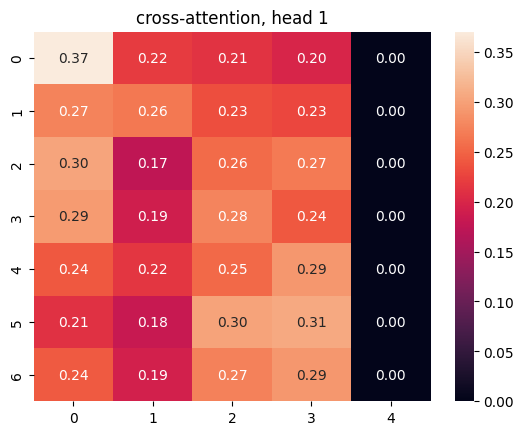

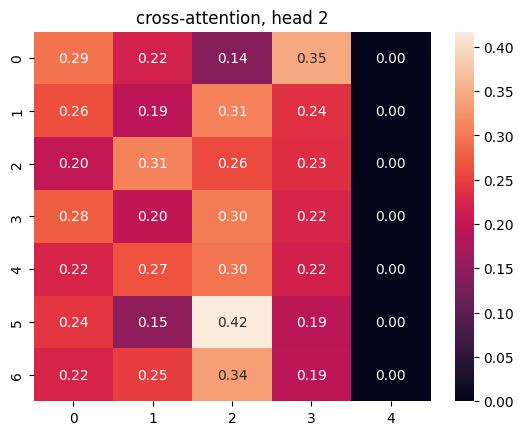

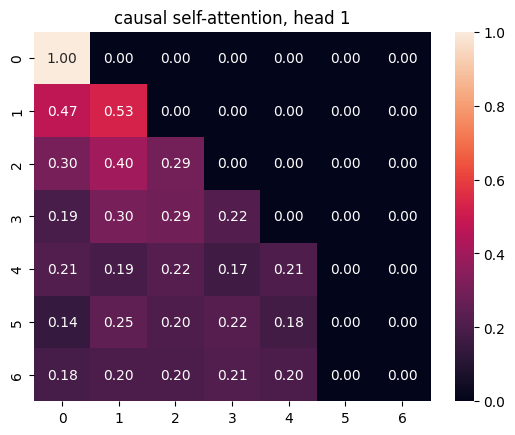

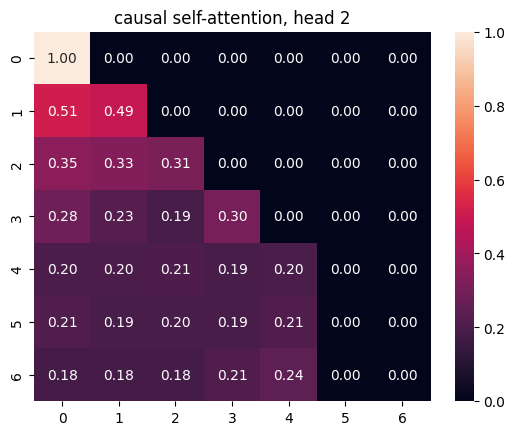

In [9]:
import seaborn as sns

embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True # The last encoder token is a padding tokens

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True # The last two decoder tokens are padding token


cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)

cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Make sure your outputs have the right hapes
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

# Check that the attention weights are normalized
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()


import matplotlib.pyplot as plt

def plot_attention_matrix(attention_matrix, title):
    """Creates a new figure and plots the normalized attention weights as a heatmap.

    This should provide a colorbar for the scale of the heatmap and label the axes "query token position" and "key token position".
    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    # TODO Implement this function

    sns.heatmap(attention_matrix, annot=True, fmt=".2f", cbar=True)
    plt.title(title)
    plt.show()

plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "causal self-attention, head 2")

In [10]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                    used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                    used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)

        # TODO Initialize the module and its parameters here.
        # You should use `nn.Embedding` for both token embeddings and positional embeddings


    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """

        # TODO Implement this function
        # Hint: you can access the weight parameter matrix via .weight of an nn.Embedding module:
        # Example:
        # ```embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # assert list(embeddings.weight.shape) == [num_embeddings, embedding_dim]```
        # torch.matmul or F.linear may also be useful here.

        logits = torch.matmul(decoder_output, self.token_embeddings.weight.T)
        return logits

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """

        # TODO Implement the forward pass of the embedding layer.
        # IMPORTANT: For full credit, you should not use python loops!

        embedding = self.token_embeddings(input_ids)
        pos = self.position_embeddings(torch.arange(input_ids.shape[1]))
        embedding = embedding + pos
        # print(embedding.shape)
        return embedding

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(hidden_dropout_prob))
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        """
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states

In [12]:
class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """

        super().__init__()
        # TODO Register the input embedding modules and the encoder and decoder blocks.
        # You should use the TransformerBlock and TransformerEmbeddings sub-modules.
        #
        # Hint: Check out `nn.ModuleList` to register a variable number of sub-modules.

        self.source_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        self.target_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)
        # Encoder blocks
        self.encoder_blocks = nn.ModuleList([TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=False)
                                              for _ in range(num_encoder_layers)])

        # Decoder blocks
        self.decoder_blocks = nn.ModuleList([TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=True)
                                              for _ in range(num_decoder_layers)])

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """

        # TODO Implement this function

        encoder_embeddings = self.source_embeddings(input_ids)
        for eb in self.encoder_blocks:
            encoder_embeddings = eb(encoder_embeddings, padding_mask)
        return encoder_embeddings

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocabulary_size)
            containing the logits for predicting the next token in the target sequence.
        """

        # TODO Implement this function

        decoder_embeddings=self.target_embeddings(input_ids)
        for db in self.decoder_blocks:
          decoder_embeddings = db(decoder_embeddings, padding_mask, encoder_outputs, encoder_padding_mask)

        logits = self.target_embeddings.compute_logits(decoder_embeddings)
        return logits

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)
        return decoder_logits

## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.
Before you start training models, you should implement and test the model and its sub-modules, especially the attention.

First, we implement a `collate` function, which takes a list of examples from the dataset and forms a batch,
consisting of padded encoder and decoder input ids, as well as encoder and decoder padding masks.

In [13]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    for i, example in enumerate(examples):
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

Next, we provide a simple training loop.

In [19]:
import time
import math

def compute_loss_per_token(model, batch):
    logits = model(**batch)

    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]

    return F.cross_entropy(logits, labels, reduction='none')


def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for batch in dev_loader:
            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl


def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')


    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()

            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size
            loss.backward()

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

Let's train a relatively small model architecture for 15 epochs.
With a reasonable implementation, this should take about 16 minutes on CPU / 3 minutes on GPU and we should achieve a validation perplexity of below 10!

In [20]:
# Set a random seed, so you obtain the same output model if you run this cell again.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    hidden_size=32,
    intermediate_size=32 * 4,
    num_attention_heads=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    max_sequence_length=32,
    hidden_dropout_prob=0.1,
    )

print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=15, model_path="model.pt")

Model architecture: EncoderDecoderModel(
  (source_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (target_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (encoder_blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (Q_projection): Linear(in_features=32, out_features=32, bias=True)
        (K_projection): Linear(in_features=32, out_features=32, bias=True)
        (V_projection): Linear(in_features=32, out_features=32, bias=True)
        (output_projection): Linear(in_features=32, out_features=32, bias=True)
      )
      (self_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32,

## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

In [21]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0) # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool) # No padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0) # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool) # No padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs)

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]

            if new_completed_scores.max() > best_score:
                best_score = new_completed_scores.max()
                best_generation = new_completed_generations[new_completed_scores.argmax()]

        if best_score >= new_scores.max():
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0]

    return best_generation, best_score.cpu().item()


def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)


    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [22]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

Use device: cpu


100%|██████████| 486/486 [00:47<00:00, 10.15it/s]



Corpus BLEU: 48.715555015509096


Let's look at some examples. What do you think of the quality of the translations?

In [23]:
# Feel free to change the range to look at more samples!
for k in range(10, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 10 =====
Input:  vous me mettez mal a l aise .
Gold:  you re embarrassing me .
Pred:  you re leaving friends me .
===== Sample 11 =====
Input:  c est toi le professeur .
Gold:  you re the teacher .
Pred:  you re the teacher .
===== Sample 12 =====
Input:  elle sourit avec bonheur .
Gold:  she smiled happily .
Pred:  she is very good ating .
===== Sample 13 =====
Input:  je ne suis pas devin .
Gold:  i m not a psychic .
Pred:  i m not allowed .
===== Sample 14 =====
Input:  vous allez perdre .
Gold:  you re going to lose .
Pred:  you re going back .
===== Sample 15 =====
Input:  vous me touchez .
Gold:  you re touching me .
Pred:  you re getting such .
===== Sample 16 =====
Input:  je pars aujourd hui .
Gold:  i m leaving today .
Pred:  i m really old .
===== Sample 17 =====
Input:  je ne suis pas une sainte .
Gold:  i m no saint .
Pred:  i m not a early .
===== Sample 18 =====
Input:  je suis puissant .
Gold:  i m powerful .
Pred:  i m early .
===== Sample 19 =====
Input: 

# Questions

Please answer written questions from the assignment in this section. You can alter the provided code to obtain the answers, but be careful not to break anything!

**(b) (4 points)**

- (i)
    What vocabulary size are we using for the source and target language?

- (ii)
    Approximately how many source and target tokens are on average contained in a training batch? What proportion of these tokens are `<pad>` tokens on average?

- (iii)
What is the specific purpose of saving the model parameters in a file `model.pt` throughout training in the code we provide?

**(c) (2 points)**
Manually look at some results and compare them with the gold answers. What do you think of the quality of the translations? Are these grammatical English sentences? Can you identify any common mistakes?

**(d) (4 points)**
Consider the provided beam search method. This implementation is not efficient and performs a lot of repeated computation. Identify the issue and propose how you can fix it.
In particular, describe how would you have to change the arguments and return values of your EncoderDecoderModel and its sub-modules?